# Probabilistic Forecasting: Bootstrapped Residuals

## Prediction intervals

Forecasting intervals with bootstrapped residuals is a method used to estimate the uncertainty in predictions by resampling past prediction errors (residuals). The goal is to generate prediction intervals that capture the variability in the forecast, giving a range of possible future values instead of just a single point estimate.

The error of a one-step-ahead forecast is defined as the difference between the actual value and the predicted value ($e_t = y_t - \hat{y}_{t|t-1}$). By assuming that future errors will be similar to past errors, it is possible to simulate different predictions by taking samples from the collection of errors previously seen in the past (i.e., the residuals) and adding them to the predictions.

<p style="text-align: center">
<img src="../img/diagram-bootstrapping-prediction-intervals.png" style="width: 500px;">
<br>
<font size="2.5"> <i>Diagram bootstrapping prediction process.</i></font>
</p>

Repeatedly performing this process creates a collection of slightly different predictions, which represent the distribution of possible outcomes due to the expected variance in the forecasting process.

<p style="text-align: center">
<img src="../img/diagram-bootstrapping-prediction-intervals-2.png" style="width: 500px;">
<br>
<font size="2.5"> <i>Bootstrapping predictions.</i></font>
</p>

Using the outcome of the bootstrapping process, prediction intervals can be computed by calculating the $α/2$ and $1 − α/2$ percentiles at each forecasting horizon. 

<p style="text-align: center">
<img src="../img/forecasting-intervals.gif" style="width: 800px;">
</p>

Alternatively, it is also possible to fit a parametric distribution for each forecast horizon. 

One of the main advantages of this strategy is that it requires only a single model to estimate any interval. However, performing hundreds or thousands of bootstrapping iterations can be computationally expensive and may not always be feasible.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

<p>For more examples on how to use probabilistic forecasting, check out the following articles:</p>
<ul>
    <li>
        <a href="https://cienciadedatos.net/documentos/py42-probabilistic-forecasting" target="_blank">
            Probabilistic forecasting with machine learning
        </a>
    </li>
    <li>
        <a href="https://cienciadedatos.net/documentos/py60-probabilistic-forecasting-prediction-intervals-multi-step-forecasting" target="_blank">
            Probabilistic forecasting: prediction intervals for multi-step time series forecasting
        </a>
    </li>
    <li>
        <a href="../faq/probabilistic-forecasting-crps-score.html" target="_blank">
            Continuous Ranked Probability Score (CRPS) in probabilistic forecasting
        </a>
    </li>
</ul>


</div>

### Libraries and data

In [74]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from skforecast.plot import set_dark_theme
from skforecast.plot import plot_residuals
from skforecast.plot import plot_prediction_distribution
from skforecast.plot import plot_prediction_intervals
from pprint import pprint

# Modelling and Forecasting
# ==============================================================================
from scipy.stats import norm
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from feature_engine.datetime import DatetimeFeatures
from feature_engine.creation import CyclicalFeatures
from skforecast.recursive import ForecasterRecursive
from skforecast.preprocessing import RollingFeatures
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster
from skforecast.metrics import calculate_coverage

# Configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')
plt.style.use('seaborn-v0_8-darkgrid')

In [75]:
# Data download
# ==============================================================================
data = fetch_dataset(name='ett_m2')
data = data[['OT']]
data.head(2)

ett_m2
------
Data from an electricity transformer station was collected between July 2016 and
July 2018 (2 years x 365 days x 24 hours x 4 intervals per hour = 70,080 data
points). Each data point consists of 8 features, including the date of the
point, the predictive value "Oil Temperature (OT)", and 6 different types of
external power load features: High UseFul Load (HUFL), High UseLess Load (HULL),
Middle UseFul Load (MUFL), Middle UseLess Load (MULL), Low UseFul Load (LUFL),
Low UseLess Load(LULL).
Zhou, Haoyi & Zhang, Shanghang & Peng, Jieqi & Zhang, Shuai & Li, Jianxin &
Xiong, Hui & Zhang, Wancai. (2020). Informer: Beyond Efficient Transformer for
Long Sequence Time-Series Forecasting.
[10.48550/arXiv.2012.07436](https://arxiv.org/abs/2012.07436).
https://github.com/zhouhaoyi/ETDataset
Shape of the dataset: (69680, 7)


,OT
date,
2016-07-01 00:00:00,38.661999
2016-07-01 00:15:00,38.223000


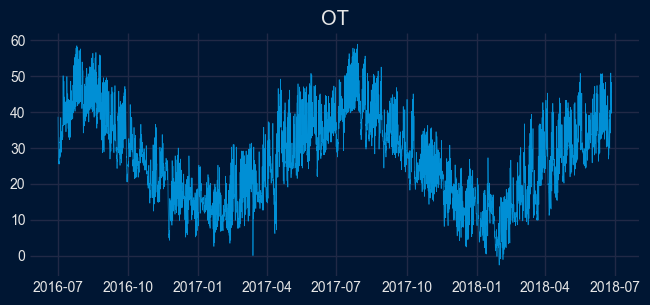

In [76]:
# Plot target time series
# ==============================================================================
set_dark_theme()
plt.rcParams['lines.linewidth'] = 0.5
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(data['OT'])
ax.set_title("OT");

In [77]:
# Calendar features
# ==============================================================================
features_to_extract = [
    'year',
    'month',
    'week',
    'day_of_week',
    'hour'
]
calendar_transformer = DatetimeFeatures(
    variables           = 'index',
    features_to_extract = features_to_extract,
    drop_original       = False,
)

# Cliclical encoding of calendar features
# ==============================================================================
features_to_encode = [
    "month",
    "week",
    "day_of_week",
    "hour",
]
max_values = {
    "month": 12,
    "week": 52,
    "day_of_week": 7,
    "hour": 24,
}
cyclical_encoder = CyclicalFeatures(
                        variables     = features_to_encode,
                        max_values    = max_values,
                        drop_original = True
                   )

exog_transformer = make_pipeline(
                        calendar_transformer,
                        cyclical_encoder
                   )
display(exog_transformer)

data = exog_transformer.fit_transform(data)
# Remove rows with NaNs created by lag features
data = data.dropna()
exog_features = data.columns.difference(['OT']).tolist()
display(data.head(3))

Pipeline(steps=[('datetimefeatures',
                 DatetimeFeatures(drop_original=False,
                                  features_to_extract=['year', 'month', 'week',
                                                       'day_of_week', 'hour'],
                                  variables='index')),
                ('cyclicalfeatures',
                 CyclicalFeatures(drop_original=True,
                                  max_values={'day_of_week': 7, 'hour': 24,
                                              'month': 12, 'week': 52},
                                  variables=['month', 'week', 'day_of_week',
                                             'hour']))])

,OT,year,month_sin,month_cos,week_sin,week_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos
date,,,,,,,,,,
2016-07-01 00:00:00,38.661999,2016,-0.5,-0.866025,1.224647e-16,-1.0,-0.433884,-0.900969,0.0,1.0
2016-07-01 00:15:00,38.223000,2016,-0.5,-0.866025,1.224647e-16,-1.0,-0.433884,-0.900969,0.0,1.0
2016-07-01 00:30:00,37.344002,2016,-0.5,-0.866025,1.224647e-16,-1.0,-0.433884,-0.900969,0.0,1.0


In [78]:
# Split train-validation-test
# ==============================================================================
end_train = '2017-10-01 23:59:00'
end_validation = '2018-04-03 23:59:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2016-07-01 00:00:00 --- 2017-10-01 23:45:00  (n=43968)
Dates validacion : 2017-10-02 00:00:00 --- 2018-04-03 23:45:00  (n=17664)
Dates test       : 2018-04-04 00:00:00 --- 2018-06-26 19:45:00  (n=8048)


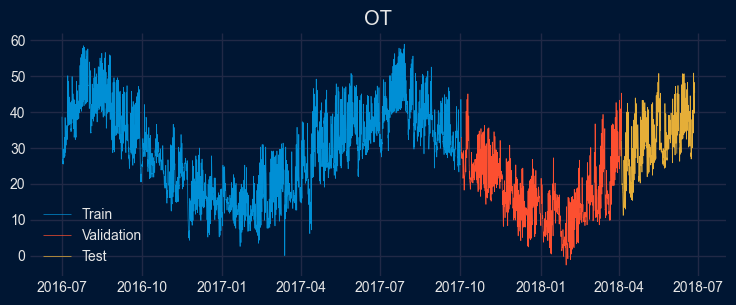

In [79]:
# Plot partitions
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(data_train['OT'], label='Train')
ax.plot(data_val['OT'], label='Validation')
ax.plot(data_test['OT'], label='Test')
ax.set_title('OT')
ax.legend();

### Intervals with In-sample residuals

By default, intervals can be computed using in-sample residuals (residuals from the training set), either by calling the `predict_interval()` method, or by performing a full [backtesting](../user_guides/backtesting.html) procedure. However, this can result in intervals that are too narrow (overly optimistic).

In [82]:
# Create and fit forecaster
# ==============================================================================
# params = {
#     "n_estimators": 400,
#     "max_depth": 5,
#     "min_data_in_leaf": 207,
#     "learning_rate": 0.102,
#     "feature_fraction": 1.0,
#     "max_bin": 250,
#     "reg_alpha": 0.8,
#     "reg_lambda": 0.0,
# }

params = {
    "max_depth": 5,
}
lags = 24
window_features = RollingFeatures(stats=["mean"], window_sizes=24 * 3)
forecaster = ForecasterRecursive(
                #  regressor       = LGBMRegressor(random_state=15926, verbose=-1, **params),
                 regressor       = Ridge(random_state=15926),
                 lags            = lags,
                 window_features = window_features,
                 differentiation = 1,
             )
forecaster.fit(
    y    = data.loc[:end_validation, 'OT'],
    exog = data.loc[:end_validation, exog_features]
)

In [83]:
# In-sample residuals stored during fit
# ==============================================================================
print("Amount of residuals stored:", len(forecaster.in_sample_residuals_))
forecaster.in_sample_residuals_

Amount of residuals stored: 10000


array([-0.05063692, -0.04980553, -0.08310507, ..., -0.41117027,
        0.23878491, -0.00285587])

In [84]:
# Predict interval with in-sample residuals
# ==============================================================================
predictions = forecaster.predict_interval(
                  exog     = data_test[exog_features],
                  steps    = 7,
                  interval = [10, 90],
                  method   = 'bootstrapping',
              )
predictions

,pred,lower_bound,upper_bound
2018-04-04 00:00:00,32.117139,31.898690,32.314264
2018-04-04 00:15:00,31.926338,31.548765,32.247725
2018-04-04 00:30:00,31.757897,31.224954,32.220364
2018-04-04 00:45:00,31.621115,30.947839,32.211250
2018-04-04 01:00:00,31.467313,30.672904,32.206765
2018-04-04 01:15:00,31.314916,30.368784,32.192735
2018-04-04 01:30:00,31.172356,30.049460,32.139616


The `backtesting_forecaster()` function is used to generate the prediction intervals for the entire test set and calculate coverage of a given interval.

+ `use_in_sample_residuals = True` is used to compute the intervals using in-sample residuals.

+ The `interval` argument indicates the desired coverage probability of the prediction intervals. In this case, `interval` is set to `[10, 90]`, which means that the prediction intervals are calculated for the 10th and 90th percentiles, resulting in a theoretical coverage probability of 80%. 

+ `interval_method` is used to specify the method used to calculate the prediction intervals. In this case, the `bootstrapped` method is used to generate the intervals using bootstrapped residuals.

+ The `n_boot` argument is used to specify the number of bootstrap samples to be used in estimating the prediction intervals. The larger the number of samples, the more accurate the prediction intervals will be, but the longer the calculation will take.

In [85]:
# Backtesting with prediction intervals in test data using in-sample residuals
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 24, 
         initial_train_size = len(data.loc[:end_validation]),
         differentiation    = 1,
         refit              = False
     )

metric, predictions = backtesting_forecaster(
                          forecaster              = forecaster,
                          y                       = data['OT'],
                          exog                    = data[exog_features],
                          cv                      = cv,
                          metric                  = 'mean_absolute_error',
                          interval                = [10, 90],  # 80% prediction interval
                          interval_method         = 'bootstrapping',
                          n_boot                  = 150,
                          use_in_sample_residuals = True,  # Use in-sample residuals
                          use_binned_residuals    = False,
                          n_jobs                  = 'auto',
                          verbose                 = False,
                          show_progress           = True
                      )

predictions.head(5)

  0%|          | 0/336 [00:00<?, ?it/s]

,pred,lower_bound,upper_bound
2018-04-04 00:00:00,32.117139,31.887355,32.296070
2018-04-04 00:15:00,31.926338,31.568709,32.243887
2018-04-04 00:30:00,31.757897,31.229470,32.177025
2018-04-04 00:45:00,31.621115,30.933127,32.205970
2018-04-04 01:00:00,31.467313,30.642984,32.195092


Predicted interval coverage: 71.48 %
Area of the interval: 25409.17


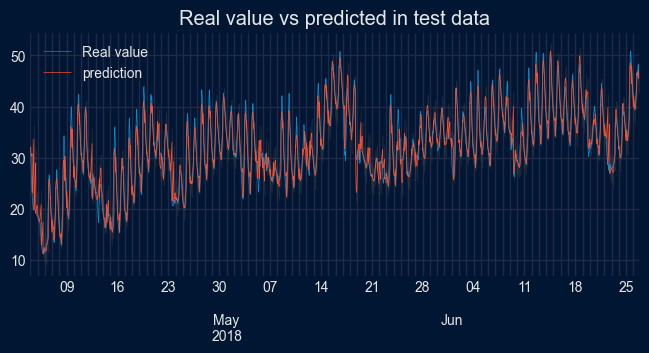

In [86]:
# Plot intervals
# ==============================================================================
plot_prediction_intervals(
    predictions     = predictions,
    y_true          = data_test,
    target_variable = "OT",
    #initial_x_zoom  = ['2012-12-01', '2012-12-20'],
    title           = "Real value vs predicted in test data",
    xaxis_title     = "",
    yaxis_title     = "",
)

# Predicted interval coverage (on test data)
# ==============================================================================
coverage = calculate_coverage(
    y_true = data.loc[end_validation:, 'OT'],
    lower_bound = predictions["lower_bound"], 
    upper_bound = predictions["upper_bound"]
)
print(f"Predicted interval coverage: {round(100 * coverage, 2)} %")

# Area of the interval
# ==============================================================================
area = (predictions["upper_bound"] - predictions["lower_bound"]).sum()
print(f"Area of the interval: {round(area, 2)}")

The prediction intervals exhibit overconfidence as they tend to be excessively narrow, resulting in a true coverage that falls below the nominal coverage (80 %). This phenomenon arises from the tendency of in-sample residuals to often overestimate the predictive capacity of the model.

### Out-sample residuals (non-conditioned on predicted values)

To address the issue of overoptimistic intervals, it is possible to use out-sample residuals (residuals from a validation set not seen during training) to estimate the prediction intervals. These residuals can be obtained through backtesting.

In [87]:
# Backtesting on validation data to obtain out-sample residuals
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 24, 
         initial_train_size = len(data.loc[:end_train]),
         differentiation    = 1,
         refit              = False
     )

_, predictions_val = backtesting_forecaster(
                         forecaster    = forecaster,
                         y             = data.loc[:end_validation, 'OT'],
                         exog          = data.loc[:end_validation, exog_features],
                         cv            = cv,
                         metric        = 'mean_absolute_error',
                         n_jobs        = 'auto',
                         verbose       = False,
                         show_progress = True
                     )

  0%|          | 0/736 [00:00<?, ?it/s]

negative    9238
positive    8426
Name: count, dtype: int64


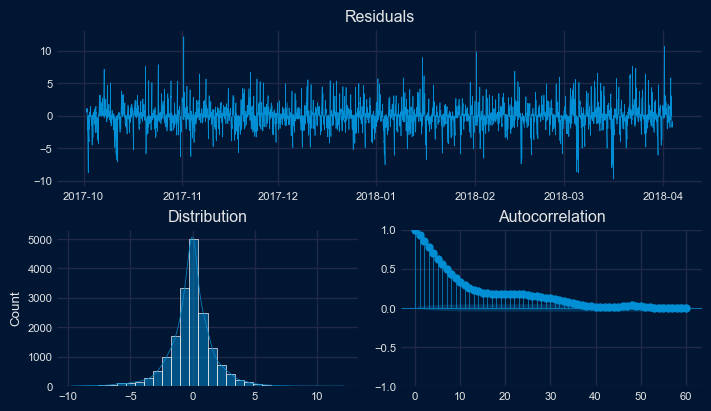

In [88]:
# Out-sample residuals distribution
# ==============================================================================
residuals = data.loc[predictions_val.index, 'OT'] - predictions_val['pred']
print(pd.Series(np.where(residuals < 0, 'negative', 'positive')).value_counts())
plt.rcParams.update({'font.size': 8})
_ = plot_residuals(residuals=residuals, figsize=(7, 4))

Then, `set_out_sample_residuals()` method is used to specify the computed out-sample residuals.

In [89]:
# Store out-sample residuals in the forecaster
# ==============================================================================
forecaster.set_out_sample_residuals(
    y_true = data.loc[predictions_val.index, 'OT'], 
    y_pred = predictions_val['pred']
)

Now that the new residuals have been added to the forecaster, the prediction intervals can be calculated using `use_in_sample_residuals = False`.

In [90]:
# Backtesting with prediction intervals in test data using out-sample residuals
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 24, 
         initial_train_size = len(data.loc[:end_validation]),
         differentiation    = 1,
         refit              = False
     )

metric, predictions = backtesting_forecaster(
                          forecaster              = forecaster,
                          y                       = data['OT'],
                          exog                    = data[exog_features],
                          cv                      = cv,
                          metric                  = 'mean_absolute_error',
                          interval                = [10, 90],  # 80% prediction interval
                          interval_method         = 'bootstrapping',
                          n_boot                  = 150,
                          use_in_sample_residuals = False,  # Use out-sample residuals
                          use_binned_residuals    = False,
                          n_jobs                  = 'auto',
                          verbose                 = False,
                          show_progress           = True
                     )
predictions.head(5)

  0%|          | 0/336 [00:00<?, ?it/s]

,pred,lower_bound,upper_bound
2018-04-04 00:00:00,32.117139,31.879801,32.499355
2018-04-04 00:15:00,31.926338,31.472465,32.431206
2018-04-04 00:30:00,31.757897,31.149441,32.446523
2018-04-04 00:45:00,31.621115,30.741678,32.709513
2018-04-04 01:00:00,31.467313,30.627225,32.766497


Predicted interval coverage: 90.68 %
Area of the interval: 57357.71


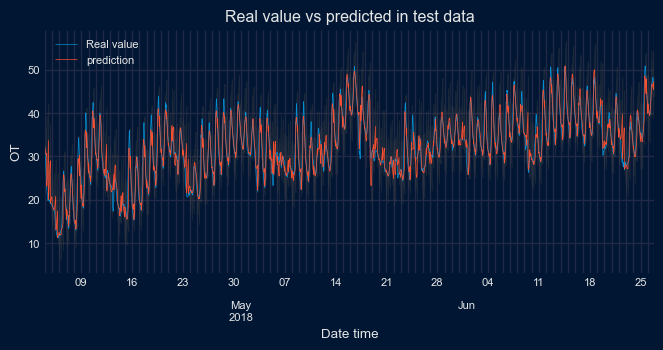

In [91]:
# Plot intervals
# ==============================================================================
plot_prediction_intervals(
    predictions     = predictions,
    y_true          = data_test,
    target_variable = "OT",
    #initial_x_zoom  = ['2012-12-01', '2012-12-20'],
    title           = "Real value vs predicted in test data",
    xaxis_title     = "Date time",
    yaxis_title     = "OT",
)

# Predicted interval coverage (on test data)
# ==============================================================================
coverage = calculate_coverage(
    y_true      = data.loc[end_validation:, 'OT'],
    lower_bound = predictions["lower_bound"], 
    upper_bound = predictions["upper_bound"]
)
print(f"Predicted interval coverage: {round(100 * coverage, 2)} %")

# Area of the interval
# ==============================================================================
area = (predictions["upper_bound"] - predictions["lower_bound"]).sum()
print(f"Area of the interval: {round(area, 2)}")

The resulting prediction intervals derived from the out-sample residuals are wider than those generated using the in-sample residuals. This results in an empirical coverage that is closer to the nominal coverage (80 %), although still lower. Examining the plot, it is easy to see that the intervals are particularly wide when the predicted values are low, indicating that the model is not able to properly locate the uncertainty of its predictions.

### Intervals conditioned on predicted values (binned residuals)

The bootstrapping process assumes that the residuals are independently distributed so that they can be used independently of the predicted value. In reality, this is rarely true; in most cases, the magnitude of the residuals is correlated with the magnitude of the predicted value. In this case, for example, one would hardly expect the error to be the same when the predicted number of OT is close to zero as when it is in the hundreds.

To account for the dependence between the residuals and the predicted values, skforecast allows to **partition the residuals into *K* bins**, where each bin is associated with a range of predicted values. Using this strategy, the bootstrapping process samples the residuals from different bins depending on the predicted value, which can improve the coverage of the interval while adjusting the width if necessary, allowing the model to **better distribute the uncertainty of its predictions**.

Internally, skforecast uses a [`QuantileBinner`](../api/preprocessing.html#skforecast.preprocessing.preprocessing.QuantileBinner) class to bin data into quantile-based bins using `numpy.percentile`. This class is similar to [KBinsDiscretizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html) but faster for binning data into quantile-based bins. Bin intervals are defined following the convention: bins[i-1] <= x < bins[i]. The binning process can be adjusted using the argument `binner_kwargs` of the Forecaster object.

In [100]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 #regressor       = LGBMRegressor(random_state=15926, verbose=-1, **params),f
                 regressor       = Ridge(random_state=15926),
                 lags            = lags,
                 differentiation = 1,
                 binner_kwargs   = {'n_bins': 10}   
             )
forecaster.fit(
    y    = data.loc[:end_validation, 'OT'],
    exog = data.loc[:end_validation, exog_features]
)

During the training process, the forecaster uses the in-sample predictions to define the intervals at which the residuals are stored depending on the predicted value to which they are related (`binner_intervals_` attribute). 

Although not used in this example, the in-sample residuals are divided into bins and stored in the `in_sample_residuals_by_bin_` attribute.

In [101]:
# Intervals of the residual bins
# ==============================================================================
pprint(forecaster.binner_intervals_)

{0: (-4.174382677907332, -0.2825264570700839),
 1: (-0.2825264570700839, -0.17238301470472633),
 2: (-0.17238301470472633, -0.12181482993443803),
 3: (-0.12181482993443803, -0.08702609730124719),
 4: (-0.08702609730124719, -0.04734877018300368),
 5: (-0.04734877018300368, 0.0051215727637267386),
 6: (0.0051215727637267386, 0.07636383376391127),
 7: (0.07636383376391127, 0.1789054846147343),
 8: (0.1789054846147343, 0.35677675993470076),
 9: (0.35677675993470076, 3.54134354599753)}


In [102]:
# Number of in-sample residuals by bin
# ==============================================================================
for k, v in forecaster.in_sample_residuals_by_bin_.items():
    print(f"Bin {k}: n={len(v)}")

Bin 0: n=1000
Bin 1: n=1000
Bin 2: n=1000
Bin 3: n=1000
Bin 4: n=1000
Bin 5: n=1000
Bin 6: n=1000
Bin 7: n=1000
Bin 8: n=1000
Bin 9: n=1000


The `set_out_sample_residuals()` method will bin the residuals according to the intervals learned during fitting. To avoid using too much memory, the number of residuals stored per bin is limited to `10_000 // self.binner.n_bins_`. The predictions obtained in the backtesting are used.

In [103]:
# Store out-sample residuals in the forecaster
# ==============================================================================
forecaster.set_out_sample_residuals(
    y_true = data.loc[predictions_val.index, 'OT'], 
    y_pred = predictions_val['pred']
)

In [104]:
# Number of out-sample residuals by bin
# ==============================================================================
for k, v in forecaster.out_sample_residuals_by_bin_.items():
    print(f"Bin {k}: n={len(v)}")

Bin 0: n=1000
Bin 1: n=1000
Bin 2: n=1000
Bin 3: n=1000
Bin 4: n=1000
Bin 5: n=1000
Bin 6: n=1000
Bin 7: n=1000
Bin 8: n=1000
Bin 9: n=1000


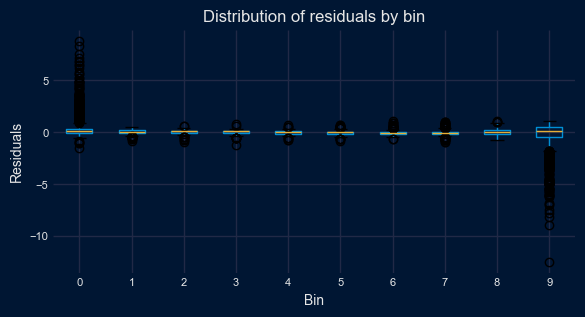

In [105]:
# Distribution of the residual by bin
# ==============================================================================
out_sample_residuals_by_bin_df = pd.DataFrame(
    dict(
        [(k, pd.Series(v))
         for k, v in forecaster.out_sample_residuals_by_bin_.items()]
    )
)

fig, ax = plt.subplots(figsize=(6, 3))
out_sample_residuals_by_bin_df.boxplot(ax=ax)
ax.set_title("Distribution of residuals by bin", fontsize=12)
ax.set_xlabel("Bin", fontsize=10)
ax.set_ylabel("Residuals", fontsize=10)
plt.show();

The box plots show how the spread and magnitude of the residuals differ depending on the predicted value. For example, for bin 0, whose predicted value is in the interval (-8.2, 11.1), the residuals never exceed an absolute value of 100, while for bin 9, for predicted values in the interval (486.2, 970.5), they often do.

Finally, the prediction intervals for the test data are estimated using the backtesting process, with out-sample residuals conditioned on the predicted values.

In [106]:
# Backtesting with prediction intervals in test data using out-sample residuals
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 24, 
         initial_train_size = len(data.loc[:end_validation]),
         differentiation    = 1,
         refit              = False
     )
metric, predictions = backtesting_forecaster(
                          forecaster              = forecaster,
                          y                       = data['OT'],
                          exog                    = data[exog_features],
                          cv                      = cv,
                          metric                  = 'mean_absolute_error',
                          interval                = [10, 90],  # 80% prediction interval
                          interval_method         = 'bootstrapping',
                          n_boot                  = 150,
                          use_in_sample_residuals = False,  # Use out-sample residuals
                          use_binned_residuals    = True,   # Use binned residuals
                          n_jobs                  = 'auto',
                          verbose                 = False,
                          show_progress           = True
                     )
predictions.head(3)

  0%|          | 0/336 [00:00<?, ?it/s]

,pred,lower_bound,upper_bound
2018-04-04 00:00:00,32.169122,32.017962,32.287891
2018-04-04 00:15:00,32.032007,31.773498,32.306656
2018-04-04 00:30:00,31.926526,31.615022,32.298671


Predicted interval coverage: 60.41 %
Area of the interval: 37759.47


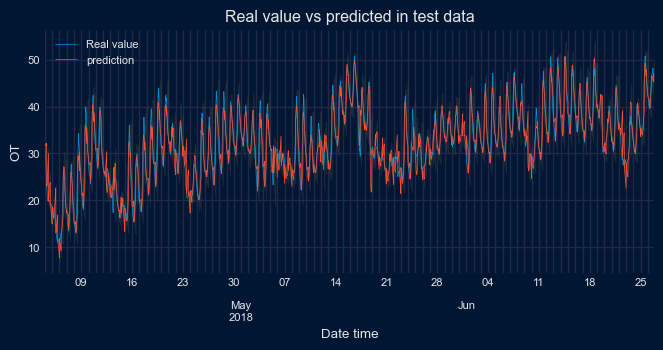

In [109]:
# Plot intervals
# ==============================================================================
plot_prediction_intervals(
    predictions     = predictions,
    y_true          = data_test,
    target_variable = "OT",
    #initial_x_zoom  = ['2012-12-01', '2012-12-20'],
    title           = "Real value vs predicted in test data",
    xaxis_title     = "Date time",
    yaxis_title     = "OT",
)

# Predicted interval coverage (on test data)
# ==============================================================================
coverage = calculate_coverage(
    y_true      = data.loc[end_validation:, 'OT'],
    lower_bound = predictions["lower_bound"], 
    upper_bound = predictions["upper_bound"]
)
print(f"Predicted interval coverage: {round(100 * coverage, 2)} %")

# Area of the interval
# ==============================================================================
area = (predictions["upper_bound"] - predictions["lower_bound"]).sum()
print(f"Area of the interval: {round(area, 2)}")

When using out-sample residuals conditioned on the predicted value, the area of the interval is significantly reduced and the uncertainty is mainly allocated to the predictions with high values. The empirical coverage is slightly above the expected coverage, which means that the estimated intervals are conservative.

### Predict bootstraping, interval, quantile and distribution

The previous sections have demonstrated the use of the backtesting process to estimate the prediction interval over a given period of time. The goal is to mimic the behavior of the model in production by running predictions at regular intervals, incrementally updating the input data.

Alternatively, it is possible to run a single prediction that forecasts *N* steps ahead without going through the entire backtesting process. In such cases, skforecast provides four different methods: `predict_bootstrapping`, `predict_interval`, `predict_quantile` and `predict_distribution`.

If the user needs to run a backtesting process using one of these prediction methods, the `interval` argument of `backtesting_forecaster()` can be specified as:

- If `list` or `tuple`: Sequence of percentiles to compute, each value must be between 0 and 100 inclusive. For example, a 95% confidence interval can be specified as `interval = [2.5, 97.5]` or multiple percentiles (e.g. 10, 50 and 90) as `interval = [10, 50, 90]`.

- If `'bootstrapping'` (str): `n_boot` bootstrapping predictions will be generated.

- If `scipy.stats distribution object`, the distribution parameters will be estimated for each prediction.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

All of these methods can be used either with in-sample or out-sample residuals using the <code>use_in_sample_residuals</code> argument, and with binned intervals conditioned on predicted values using the <code>use_binned_residuals</code> argument.

</div>

**Predict Bootstraping** 

The `predict_bootstrapping` method performs the `n_boot` bootstrapping iterations that generate the alternative prediction paths. These are the underlying values used to compute the intervals, quantiles, and distributions.

In [110]:
# Fit forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = LGBMRegressor(random_state=15926, verbose=-1, **params),
                 lags      = lags
             )
forecaster.fit(
    y    = data.loc[:end_validation, 'OT'],
    exog = data.loc[:end_validation, exog_features]
)

In [111]:
# Predict 10 different forecasting sequences of 7 steps each using bootstrapping
# ==============================================================================
boot_predictions = forecaster.predict_bootstrapping(
                       exog   = data_test[exog_features],
                       steps  = 7,
                       n_boot = 25
                   )
boot_predictions

,pred_boot_0,pred_boot_1,pred_boot_2,pred_boot_3,pred_boot_4,pred_boot_5,pred_boot_6,pred_boot_7,pred_boot_8,pred_boot_9,...,pred_boot_15,pred_boot_16,pred_boot_17,pred_boot_18,pred_boot_19,pred_boot_20,pred_boot_21,pred_boot_22,pred_boot_23,pred_boot_24
2018-04-04 00:00:00,32.184274,31.847819,31.884542,32.296690,31.621766,31.791882,31.843829,31.606142,31.962562,32.063827,...,32.133783,32.056271,31.966567,32.085071,32.222759,31.724874,31.813805,31.664313,32.033502,32.084158
2018-04-04 00:15:00,31.806660,31.561783,31.370288,32.152939,31.409434,31.837851,31.605208,31.394193,31.881490,31.902798,...,31.865559,31.932480,31.654588,31.923091,31.336514,31.362547,31.598406,31.253473,31.871858,31.604046
2018-04-04 00:30:00,31.533095,31.540216,30.962626,32.020152,31.239634,31.608440,31.485067,31.331615,31.837626,32.066835,...,31.677873,32.213335,31.400567,31.975363,31.336955,31.065769,31.313617,30.982027,31.783456,31.476817
2018-04-04 00:45:00,31.433668,31.272437,30.793811,31.985361,31.730615,31.316986,31.163819,31.004445,31.525135,31.905233,...,31.475844,32.014309,31.324029,31.157852,31.021476,30.292843,30.922257,30.753549,31.719259,31.596360
2018-04-04 01:00:00,31.452885,31.165056,30.625238,31.914769,31.362786,31.063920,31.199828,31.106185,31.117691,31.805440,...,31.307820,31.968987,31.207824,30.977139,30.870077,29.756880,30.638241,30.478117,31.607003,31.246434
2018-04-04 01:15:00,31.447802,31.009246,30.293445,31.677319,31.463512,31.022313,30.994504,31.182641,30.841989,31.575387,...,31.352127,32.501365,31.188268,31.046201,30.596589,29.490606,30.497866,30.285971,31.554937,31.129943
2018-04-04 01:30:00,31.337410,31.067175,29.783872,31.459528,31.205149,30.778776,30.782096,31.049320,30.942853,31.465801,...,31.059180,32.498482,30.825118,31.115237,30.584628,29.497956,30.741688,30.119637,31.477366,30.643549


A ridge plot is a useful way to visualize the uncertainty of a forecasting model. This plot estimates a kernel density for each step by using the bootstrapped predictions.

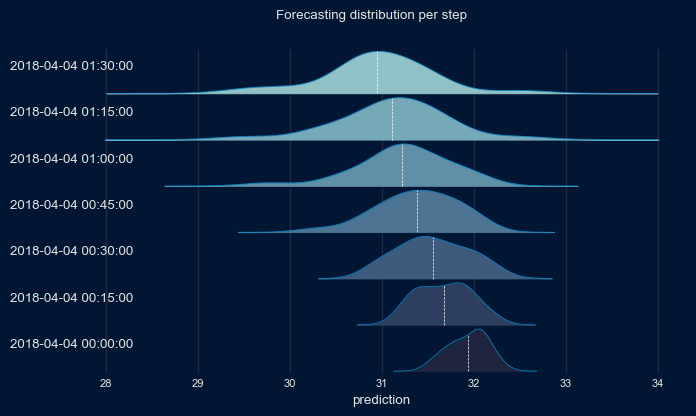

In [112]:
# Ridge plot of bootstrapping predictions
# ==============================================================================
_ = plot_prediction_distribution(boot_predictions, figsize=(7, 4))

These predictions can also be generated using `backtesting_forecaster` with the `interval` argument set to `bootstrapping`.

In [113]:
# Bootstrapping backtesting predictions
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 24, 
         initial_train_size = len(data.loc[:end_validation]),
         differentiation    = 1,
         refit              = False
     )

metric, predictions = backtesting_forecaster(
                          forecaster              = forecaster,
                          y                       = data['OT'],
                          exog                    = data[exog_features],
                          cv                      = cv,
                          metric                  = 'mean_absolute_error',
                          interval                = 'bootstrapping',  # Bootstrapping predictions
                          n_boot                  = 150,
                          use_in_sample_residuals = True,  # Use in-sample residuals
                          use_binned_residuals    = False,  
                          n_jobs                  = 'auto',
                          verbose                 = False,
                          show_progress           = True
                     )

predictions.head(3)

ValueError: The differentiation included in the forecaster (None) differs from the differentiation included in the cv (1). Set the same value for both using the `differentiation` argument.

**Predict Interval**

In most cases, the user is interested in a specific interval rather than the entire bootstrapping simulation matrix. To address this need, skforecast provides the `predict_interval` method. This method internally uses `predict_bootstrapping` to obtain the bootstrapping matrix and estimates the upper and lower quantiles for each step, thus providing the user with the desired prediction intervals.

In [ ]:
# Predict intervals for next 7 steps, quantiles 10th and 90th
# ==============================================================================
predictions = forecaster.predict_interval(
                  exog     = data_test[exog_features],
                  steps    = 7,
                  interval = [10, 90],
                  method   = 'bootstrapping',
                  n_boot   = 150
              )
predictions

,pred,lower_bound,upper_bound
2012-11-16 00:00:00,68.564290,35.803461,102.177414
2012-11-16 01:00:00,38.404249,2.682268,72.027380
2012-11-16 02:00:00,15.506338,-22.499288,49.201081
2012-11-16 03:00:00,5.994764,-21.552536,44.549299
2012-11-16 04:00:00,7.980428,-25.381259,66.418761
2012-11-16 05:00:00,22.028717,7.200691,101.110990
2012-11-16 06:00:00,93.265562,56.123659,256.541622


These predictions can also be generated using `backtesting_forecaster` with the `interval` argument as a list of two percentiles.

In [ ]:
# Interval backtesting predictions
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster              = forecaster,
                          y                       = data['OT'],
                          exog                    = data[exog_features],
                          cv                      = cv,
                          metric                  = 'mean_absolute_error',
                          interval                = [10, 90],  # Interval predictions
                          interval_method         = 'bootstrapping',
                          n_boot                  = 150,
                          use_in_sample_residuals = True,  # Use in-sample residuals
                          use_binned_residuals    = False,  
                          n_jobs                  = 'auto',
                          verbose                 = False,
                          show_progress           = True
                     )

predictions.head(3)

  0%|          | 0/45 [00:00<?, ?it/s]

,pred,lower_bound,upper_bound
2012-11-16 00:00:00,68.564290,35.803461,102.177414
2012-11-16 01:00:00,38.404249,2.682268,72.027380
2012-11-16 02:00:00,15.506338,-22.499288,49.201081


**Predict Quantile**

This method operates identically to `predict_interval`, with the added feature of enabling OT to define a specific list of quantiles for estimation at each step. It's important to remember that these quantiles should be specified within the range of 0 to 1.

In [ ]:
# Predict quantiles for next 7 steps, quantiles 5th, 25th, 75th and 95th
# ==============================================================================
predictions = forecaster.predict_quantiles(
                  exog      = data_test[exog_features],
                  steps     = 7,
                  n_boot    = 150,
                  quantiles = [0.05, 0.25, 0.75, 0.95],
              )
predictions

,q_0.05,q_0.25,q_0.75,q_0.95
2012-11-16 00:00:00,25.270855,59.441780,84.632435,120.333016
2012-11-16 01:00:00,-9.918756,22.496434,55.363641,87.698226
2012-11-16 02:00:00,-36.285453,0.318439,30.915357,63.573108
2012-11-16 03:00:00,-41.276203,-3.573881,25.250878,80.582670
2012-11-16 04:00:00,-33.147663,-0.896752,37.554600,101.499510
2012-11-16 05:00:00,-1.652237,18.877453,56.776182,168.400354
2012-11-16 06:00:00,39.156350,81.942052,158.238316,302.845420


These predictions can also be generated using `backtesting_forecaster` with the `interval` argument as a list of different percentiles.

In [ ]:
# Percentile backtesting predictions
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster              = forecaster,
                          y                       = data['OT'],
                          exog                    = data[exog_features],
                          cv                      = cv,
                          metric                  = 'mean_absolute_error',
                          interval                = [5, 25, 75, 95],  # Different percentiles
                          interval_method         = 'bootstrapping',
                          n_boot                  = 150,
                          use_in_sample_residuals = True,  # Use in-sample residuals
                          use_binned_residuals    = False,  
                          n_jobs                  = 'auto',
                          verbose                 = False,
                          show_progress           = True
                     )

predictions.head(3)

  0%|          | 0/45 [00:00<?, ?it/s]

KeyboardInterrupt: 

**Predict Distribution**

The intervals estimated so far are distribution-free, which means that no assumptions are made about a particular distribution. The `predict_dist` method in skforecast allows fitting a parametric distribution to the bootstrapped prediction samples obtained with `predict_bootstrapping`. This is useful when there is reason to believe that the forecast errors follow a particular distribution, such as the normal distribution or the student's t-distribution. The `predict_dist` method allows the user to specify any continuous distribution from the [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html#continuous-distributions) module.

In [ ]:
# Predict the parameters of a normal distribution for the next 7 steps
# ==============================================================================
predictions = forecaster.predict_dist(
                  exog         = data_test[exog_features],
                  steps        = 7,
                  n_boot       = 150,
                  distribution = norm
              )
predictions

,loc,scale
2012-11-16 00:00:00,69.246122,11.443606
2012-11-16 01:00:00,47.149645,13.731953
2012-11-16 02:00:00,21.183596,14.787970
2012-11-16 03:00:00,1.137208,11.642410
2012-11-16 04:00:00,-2.525007,12.890002
2012-11-16 05:00:00,38.478812,12.083966
2012-11-16 06:00:00,106.244365,27.686430


These predictions can also be generated using `backtesting_forecaster` with the `interval` argument as a scipy.stats distribution.

In [ ]:
# Percentile backtesting predictions
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster              = forecaster,
                          y                       = data['OT'],
                          exog                    = data[exog_features],
                          cv                      = cv,
                          metric                  = 'mean_absolute_error',
                          interval                = norm,  # Scipy distribution
                          interval_method         = 'bootstrapping',
                          n_boot                  = 150,
                          use_in_sample_residuals = True,  # Use in-sample residuals
                          use_binned_residuals    = False,  
                          n_jobs                  = 'auto',
                          verbose                 = False,
                          show_progress           = True
                     )

predictions.head(3)

  0%|          | 0/45 [00:00<?, ?it/s]

,pred,loc,scale
2012-11-16 00:00:00,70.009970,69.246122,11.443606
2012-11-16 01:00:00,45.679914,47.149645,13.731953
2012-11-16 02:00:00,19.225220,21.183596,14.787970
